**Deuxième réseau** :  
     - Similaire au premier, mais avec deux changements majeurs :  
       - Les images sont redimensionnées à 32x32 pixels.   
       - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA']

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 2
epochs = 50
crossValidationSplit = 10


In [50]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [51]:
def charger_images_par_format_cv2(chemin):
    """
    Charge des images d'un chemin spécifique dont les noms suivent le format y_x.jpeg.
    Les images sont lues en niveaux de gris, leur taille originale est respectée, 
    et leur dimension du canal est explicitement ajoutée pour éviter toute perte d'information.
    
    Paramètres :
    chemin (str) : Chemin de base où chercher les images.
    
    Retourne :
    X (np.array) : Liste des images traitées.
    y (np.array) : Liste des labels extraits des noms des fichiers.
    input_shape (tuple) : Taille des images (hauteur, largeur, canaux).
    """
    X = []
    y = []
    dimensions = None

    # Chemin pour les images respectant le format spécifié
    chemin_images = rf'{chemin}\*_*.jpeg'

    # Parcourir toutes les images correspondant au modèle
    for fichier in glob.glob(chemin_images):
        # Lire l'image en niveaux de gris
        image = cv2.imread(fichier, cv2.IMREAD_GRAYSCALE)
        if image is not None:  # Vérifier si l'image a été correctement chargée
            # Ajouter une dimension pour le canal
            image = np.expand_dims(image, axis=-1)
            X.append(image)
            
            # Vérifier et conserver la taille de la première image
            if dimensions is None:
                hauteur, largeur = image.shape[:2]
                dimensions = (hauteur, largeur, 1)  # Ajouter explicitement le canal (gris)
            
            # Extraire le label y depuis le nom de fichier
            nom = fichier.split('\\')[-1].replace('.jpeg', '')  # Récupérer le nom sans extension
            label = int(nom.split('_')[0])  # Extraire 'y' avant le '_'
            if label == 2:
                y.append(1)
            else:
                y.append(label)
        else:
            print(f"Impossible de lire l'image : {fichier}")

    # Convertir X et y en tableaux numpy
    return np.array(X), np.array(y), dimensions


In [52]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [53]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")

(5832, 32, 32, 1) échantillons d'entraînement
(32, 32, 1) input_shape
50 epochs


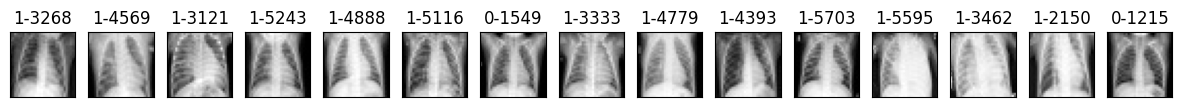

x_train (5248, 32, 32, 1) x_test (584, 32, 32, 1)
y_train (5248,) y_test (584,)


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_44 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_132               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_133               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_134               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 3s - 35ms/step - accuracy: 0.7361 - loss: 0.5503 - val_accuracy: 0.8664 - val_loss: 0.3451
Epoch 2/50
82/82 - 1s - 13ms/step - accuracy: 0.8790 - loss: 0.2907 - val_accuracy: 0.9229 - val_loss: 0.1931
Epoch 3/50
82/82 - 1s - 13ms/step - accuracy: 0.9204 - loss: 0.2015 - val_accuracy: 0.9332 - val_loss: 0.1712
Epoch 4/50
82/82 - 1s - 13ms/step - accuracy: 0.9434 - loss: 0.1607 - val_accuracy: 0.9418 - val_loss: 0.1367
Epoch 5/50
82/82 - 1s - 15ms/step - accuracy: 0.9419 - loss: 0.1500 - val_accuracy: 0.8921 - val_loss: 0.2784
Epoch 6/50
82/82 - 1s - 13ms/step - accuracy: 0.9468 - loss: 0.1423 - val_accuracy: 0.9435 - val_loss: 0.1321
Epoch 7/50
82/82 - 1s - 13ms/step - accuracy: 0.9501 - loss: 0.1304 - val_accuracy: 0.9521 - val_loss: 0.1150
Epoch 8/50
82/82 - 1s - 13ms/step - accuracy: 0.9552 - loss: 0.1189 - val_accuracy: 0.9521 - val_loss: 0.1235
Epoch 9/50
82/82 - 1s - 13ms/step - accuracy: 0.9579 - loss: 0.1095 - val_accuracy: 0.9486 - val_loss: 0.1119
Epoch

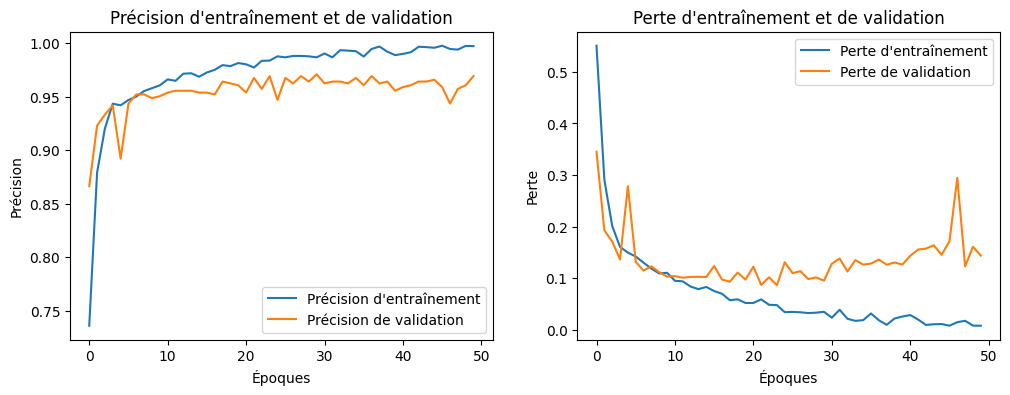

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9502 - loss: 0.2389
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 1:
perte: 0.14 précision: 0.97
AUC 0.9942
Prédictions
Counter({np.int64(1): 434, np.int64(0): 150}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.97      0.92      0.94       158
   Pneumonia       0.97      0.99      0.98       426

    accuracy                           0.97       584
   macro avg       0.97      0.95      0.96       584
weighted avg       0.97      0.97      0.97       584

Matrice de confusion


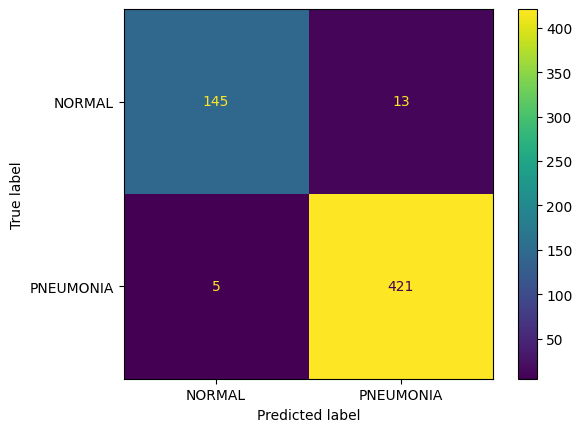

x_train (5248, 32, 32, 1) x_test (584, 32, 32, 1)
y_train (5248,) y_test (584,)


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_45 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_135 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_135               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_136               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_137               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 3s - 35ms/step - accuracy: 0.7355 - loss: 0.5513 - val_accuracy: 0.7825 - val_loss: 0.4073
Epoch 2/50
82/82 - 1s - 13ms/step - accuracy: 0.8641 - loss: 0.3239 - val_accuracy: 0.9195 - val_loss: 0.2022
Epoch 3/50
82/82 - 1s - 13ms/step - accuracy: 0.9299 - loss: 0.1834 - val_accuracy: 0.9401 - val_loss: 0.1725
Epoch 4/50
82/82 - 1s - 13ms/step - accuracy: 0.9400 - loss: 0.1580 - val_accuracy: 0.9298 - val_loss: 0.1951
Epoch 5/50
82/82 - 1s - 13ms/step - accuracy: 0.9476 - loss: 0.1404 - val_accuracy: 0.9503 - val_loss: 0.1563
Epoch 6/50
82/82 - 1s - 13ms/step - accuracy: 0.9505 - loss: 0.1368 - val_accuracy: 0.9384 - val_loss: 0.1667
Epoch 7/50
82/82 - 1s - 13ms/step - accuracy: 0.9514 - loss: 0.1278 - val_accuracy: 0.9606 - val_loss: 0.1352
Epoch 8/50
82/82 - 1s - 13ms/step - accuracy: 0.9613 - loss: 0.1028 - val_accuracy: 0.9606 - val_loss: 0.1351
Epoch 9/50
82/82 - 1s - 13ms/step - accuracy: 0.9621 - loss: 0.0998 - val_accuracy: 0.9623 - val_loss: 0.1236
Epoch

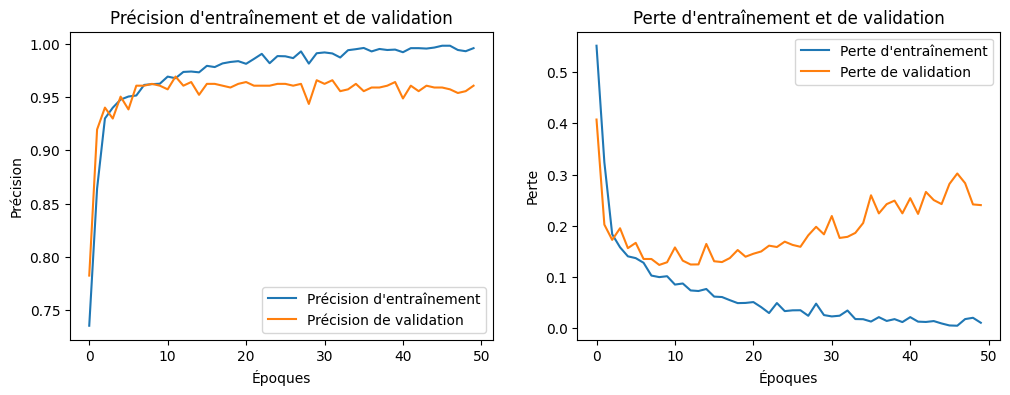

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9424 - loss: 0.3561 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 2:
perte: 0.24 précision: 0.96
AUC 0.9883
Prédictions
Counter({np.int64(1): 431, np.int64(0): 153}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.94      0.91      0.93       158
   Pneumonia       0.97      0.98      0.97       426

    accuracy                           0.96       584
   macro avg       0.95      0.95      0.95       584
weighted avg       0.96      0.96      0.96       584

Matrice de confusion


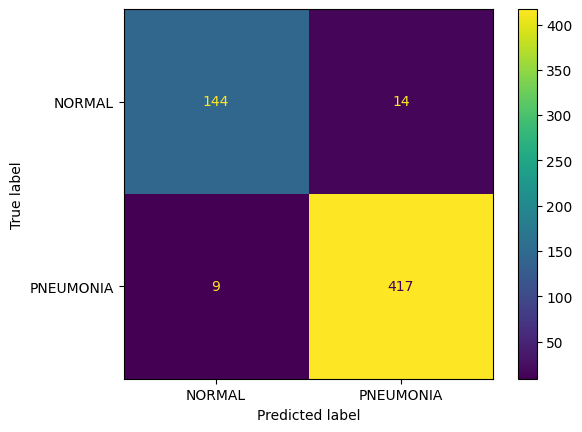

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_46 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_138               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_139               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_140               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 34ms/step - accuracy: 0.7394 - loss: 0.5480 - val_accuracy: 0.8268 - val_loss: 0.4089
Epoch 2/50
83/83 - 1s - 14ms/step - accuracy: 0.8785 - loss: 0.2883 - val_accuracy: 0.9039 - val_loss: 0.2486
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.9255 - loss: 0.2035 - val_accuracy: 0.9160 - val_loss: 0.2092
Epoch 4/50
83/83 - 1s - 13ms/step - accuracy: 0.9347 - loss: 0.1748 - val_accuracy: 0.9177 - val_loss: 0.1980
Epoch 5/50
83/83 - 1s - 13ms/step - accuracy: 0.9449 - loss: 0.1541 - val_accuracy: 0.9314 - val_loss: 0.1564
Epoch 6/50
83/83 - 1s - 14ms/step - accuracy: 0.9539 - loss: 0.1284 - val_accuracy: 0.9383 - val_loss: 0.1560
Epoch 7/50
83/83 - 1s - 13ms/step - accuracy: 0.9554 - loss: 0.1211 - val_accuracy: 0.9485 - val_loss: 0.1459
Epoch 8/50
83/83 - 1s - 13ms/step - accuracy: 0.9550 - loss: 0.1129 - val_accuracy: 0.9331 - val_loss: 0.1591
Epoch 9/50
83/83 - 1s - 14ms/step - accuracy: 0.9585 - loss: 0.1123 - val_accuracy: 0.9348 - val_loss: 0.1599
Epoch

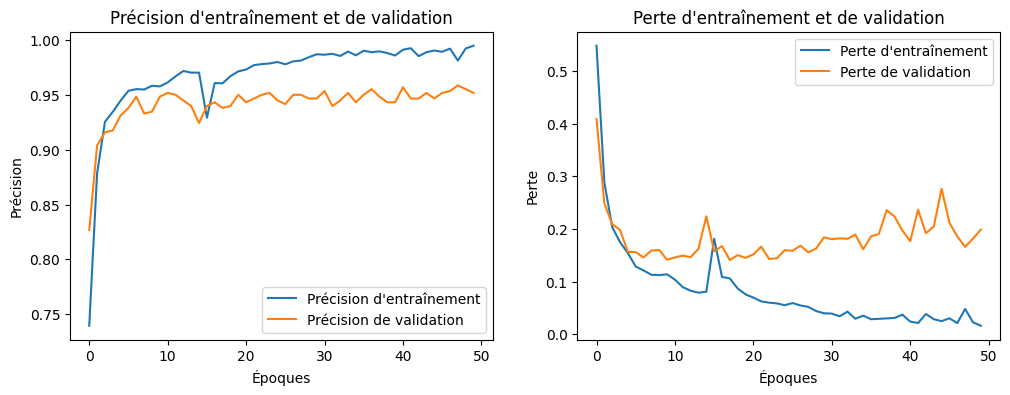

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9282 - loss: 0.2897
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 3:
perte: 0.20 précision: 0.95
AUC 0.9875
Prédictions
Counter({np.int64(1): 427, np.int64(0): 156}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.92      0.91      0.91       158
   Pneumonia       0.96      0.97      0.97       425

    accuracy                           0.95       583
   macro avg       0.94      0.94      0.94       583
weighted avg       0.95      0.95      0.95       583

Matrice de confusion


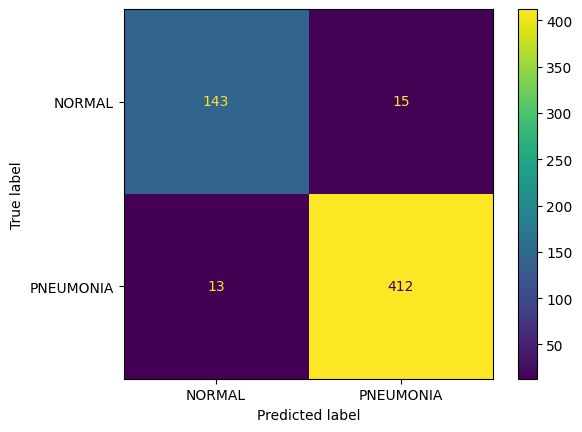

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_47 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_141               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_142 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_142               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_143 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_143               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 36ms/step - accuracy: 0.7405 - loss: 0.5470 - val_accuracy: 0.7564 - val_loss: 0.4908
Epoch 2/50
83/83 - 1s - 14ms/step - accuracy: 0.8741 - loss: 0.2890 - val_accuracy: 0.9400 - val_loss: 0.1656
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.9156 - loss: 0.2160 - val_accuracy: 0.8199 - val_loss: 0.4326
Epoch 4/50
83/83 - 1s - 14ms/step - accuracy: 0.9091 - loss: 0.2296 - val_accuracy: 0.9365 - val_loss: 0.1797
Epoch 5/50
83/83 - 1s - 14ms/step - accuracy: 0.9341 - loss: 0.1685 - val_accuracy: 0.9503 - val_loss: 0.1393
Epoch 6/50
83/83 - 1s - 14ms/step - accuracy: 0.9482 - loss: 0.1405 - val_accuracy: 0.9554 - val_loss: 0.1215
Epoch 7/50
83/83 - 1s - 14ms/step - accuracy: 0.9535 - loss: 0.1334 - val_accuracy: 0.9623 - val_loss: 0.1074
Epoch 8/50
83/83 - 1s - 14ms/step - accuracy: 0.9507 - loss: 0.1284 - val_accuracy: 0.9623 - val_loss: 0.0999
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.9596 - loss: 0.1122 - val_accuracy: 0.9623 - val_loss: 0.1036
Epoch

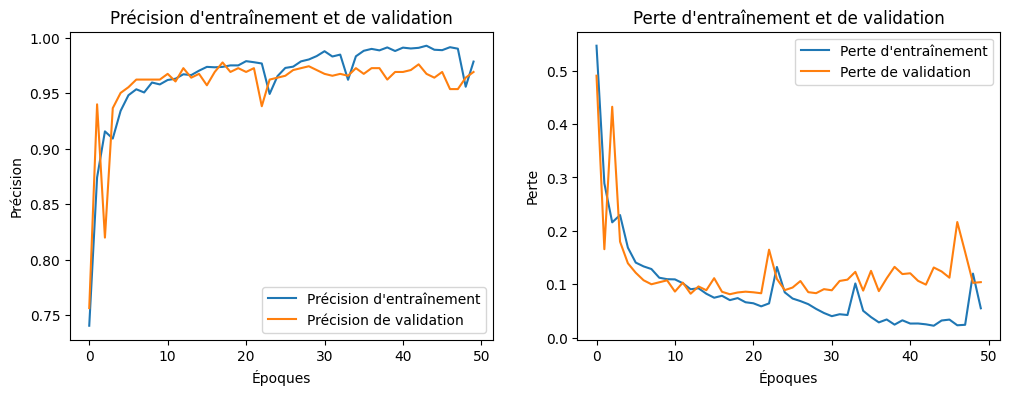

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9528 - loss: 0.1671
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 4:
perte: 0.10 précision: 0.97
AUC 0.9932
Prédictions
Counter({np.int64(1): 429, np.int64(0): 154}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       158
   Pneumonia       0.97      0.98      0.98       425

    accuracy                           0.97       583
   macro avg       0.96      0.96      0.96       583
weighted avg       0.97      0.97      0.97       583

Matrice de confusion


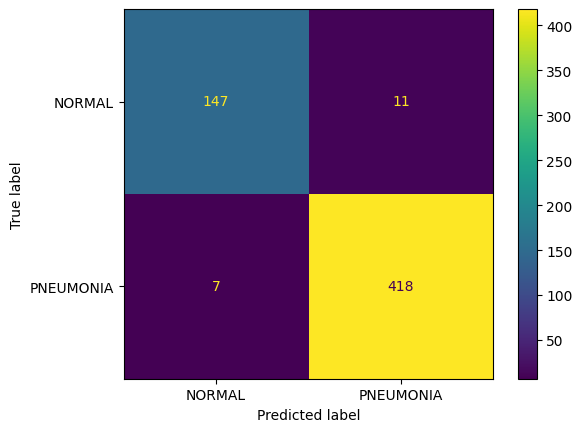

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_48 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_144 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_144               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_145               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_146 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_146               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 35ms/step - accuracy: 0.7337 - loss: 0.5567 - val_accuracy: 0.8782 - val_loss: 0.3124
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.8876 - loss: 0.2756 - val_accuracy: 0.7702 - val_loss: 0.6329
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.8950 - loss: 0.2698 - val_accuracy: 0.9348 - val_loss: 0.1665
Epoch 4/50
83/83 - 1s - 15ms/step - accuracy: 0.9390 - loss: 0.1658 - val_accuracy: 0.9365 - val_loss: 0.1405
Epoch 5/50
83/83 - 1s - 15ms/step - accuracy: 0.9423 - loss: 0.1551 - val_accuracy: 0.9434 - val_loss: 0.1428
Epoch 6/50
83/83 - 1s - 15ms/step - accuracy: 0.9488 - loss: 0.1372 - val_accuracy: 0.9434 - val_loss: 0.1371
Epoch 7/50
83/83 - 1s - 15ms/step - accuracy: 0.9524 - loss: 0.1289 - val_accuracy: 0.9005 - val_loss: 0.2432
Epoch 8/50
83/83 - 1s - 16ms/step - accuracy: 0.9566 - loss: 0.1236 - val_accuracy: 0.9554 - val_loss: 0.1195
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.9573 - loss: 0.1144 - val_accuracy: 0.9605 - val_loss: 0.1103
Epoch

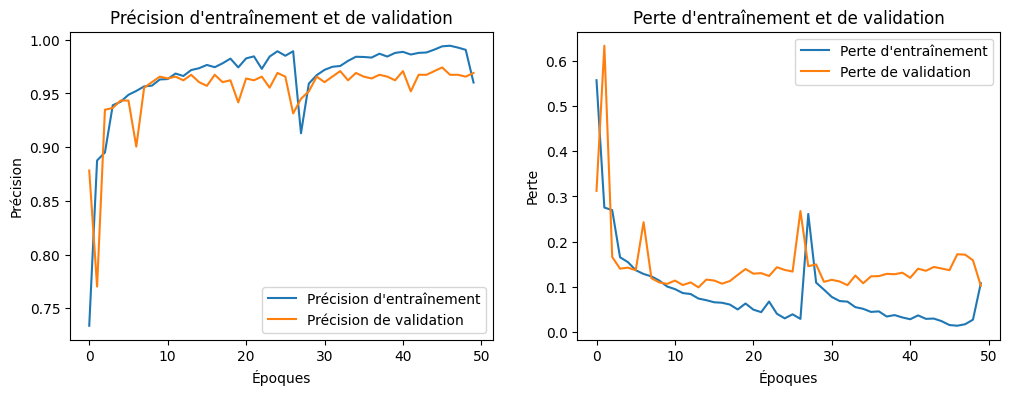

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9624 - loss: 0.1338
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Partition numéro 5:
perte: 0.10 précision: 0.97
AUC 0.9920
Prédictions
Counter({np.int64(1): 421, np.int64(0): 162}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.93      0.96      0.94       158
   Pneumonia       0.98      0.97      0.98       425

    accuracy                           0.97       583
   macro avg       0.96      0.96      0.96       583
weighted avg       0.97      0.97      0.97       583

Matrice de confusion


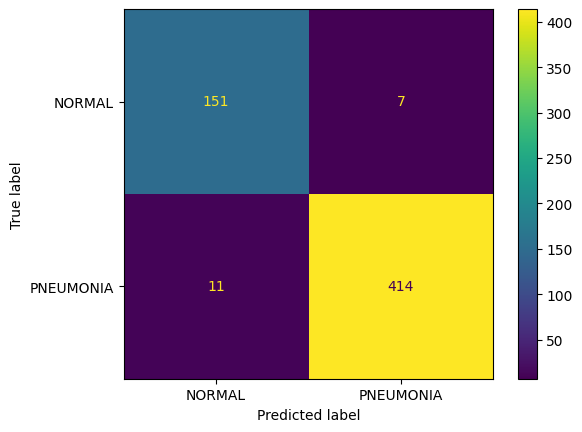

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_49 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 37ms/step - accuracy: 0.7339 - loss: 0.5578 - val_accuracy: 0.8593 - val_loss: 0.4017
Epoch 2/50
83/83 - 1s - 15ms/step - accuracy: 0.8790 - loss: 0.2872 - val_accuracy: 0.9400 - val_loss: 0.1641
Epoch 3/50
83/83 - 1s - 16ms/step - accuracy: 0.9242 - loss: 0.1962 - val_accuracy: 0.9485 - val_loss: 0.1400
Epoch 4/50
83/83 - 1s - 15ms/step - accuracy: 0.9392 - loss: 0.1705 - val_accuracy: 0.9503 - val_loss: 0.1299
Epoch 5/50
83/83 - 1s - 15ms/step - accuracy: 0.9421 - loss: 0.1580 - val_accuracy: 0.9588 - val_loss: 0.1135
Epoch 6/50
83/83 - 1s - 17ms/step - accuracy: 0.9455 - loss: 0.1506 - val_accuracy: 0.9485 - val_loss: 0.1114
Epoch 7/50
83/83 - 1s - 16ms/step - accuracy: 0.9539 - loss: 0.1302 - val_accuracy: 0.9571 - val_loss: 0.1073
Epoch 8/50
83/83 - 1s - 17ms/step - accuracy: 0.9554 - loss: 0.1245 - val_accuracy: 0.9554 - val_loss: 0.1047
Epoch 9/50
83/83 - 1s - 16ms/step - accuracy: 0.9625 - loss: 0.1084 - val_accuracy: 0.9331 - val_loss: 0.1664
Epoch

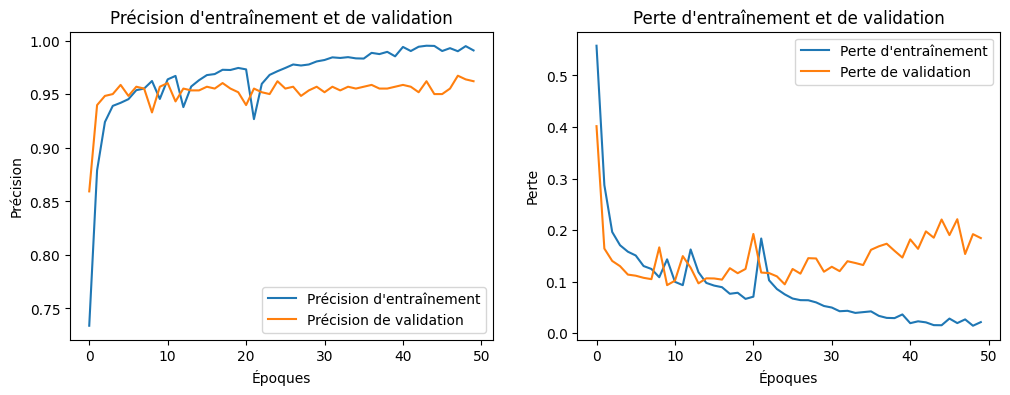

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9606 - loss: 0.2031 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 6:
perte: 0.18 précision: 0.96
AUC 0.9919
Prédictions
Counter({np.int64(1): 418, np.int64(0): 165}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       157
   Pneumonia       0.98      0.96      0.97       426

    accuracy                           0.96       583
   macro avg       0.95      0.96      0.95       583
weighted avg       0.96      0.96      0.96       583

Matrice de confusion


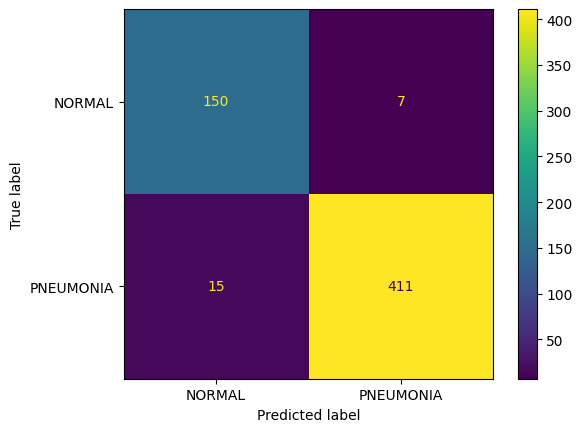

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_50 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 39ms/step - accuracy: 0.7413 - loss: 0.5477 - val_accuracy: 0.8782 - val_loss: 0.3175
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.8926 - loss: 0.2703 - val_accuracy: 0.9091 - val_loss: 0.2141
Epoch 3/50
83/83 - 1s - 16ms/step - accuracy: 0.9247 - loss: 0.2033 - val_accuracy: 0.9228 - val_loss: 0.2013
Epoch 4/50
83/83 - 1s - 17ms/step - accuracy: 0.9379 - loss: 0.1759 - val_accuracy: 0.9348 - val_loss: 0.1646
Epoch 5/50
83/83 - 1s - 17ms/step - accuracy: 0.9448 - loss: 0.1522 - val_accuracy: 0.9091 - val_loss: 0.2127
Epoch 6/50
83/83 - 1s - 16ms/step - accuracy: 0.9518 - loss: 0.1391 - val_accuracy: 0.9365 - val_loss: 0.1613
Epoch 7/50
83/83 - 1s - 16ms/step - accuracy: 0.9535 - loss: 0.1287 - val_accuracy: 0.9451 - val_loss: 0.1387
Epoch 8/50
83/83 - 1s - 16ms/step - accuracy: 0.9571 - loss: 0.1165 - val_accuracy: 0.9434 - val_loss: 0.1723
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.9166 - loss: 0.2027 - val_accuracy: 0.9451 - val_loss: 0.1572
Epoch

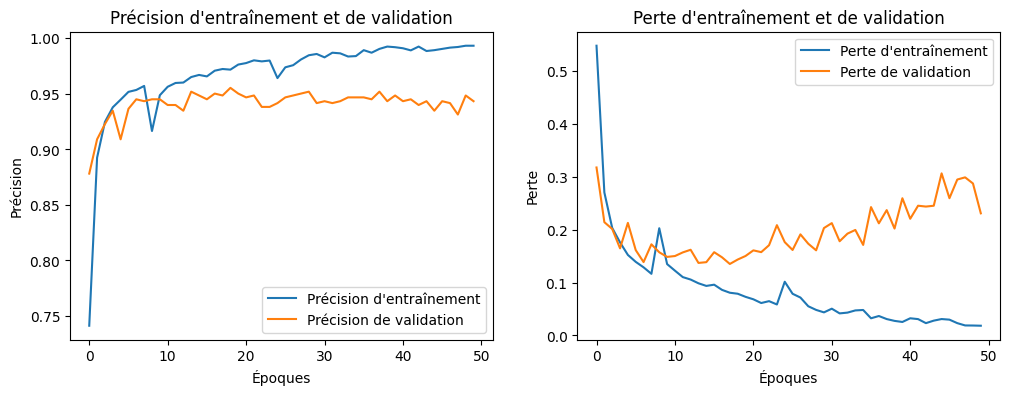

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9307 - loss: 0.2864
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Partition numéro 7:
perte: 0.23 précision: 0.94
AUC 0.9824
Prédictions
Counter({np.int64(1): 427, np.int64(0): 156}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.90      0.89      0.89       157
   Pneumonia       0.96      0.96      0.96       426

    accuracy                           0.94       583
   macro avg       0.93      0.93      0.93       583
weighted avg       0.94      0.94      0.94       583

Matrice de confusion


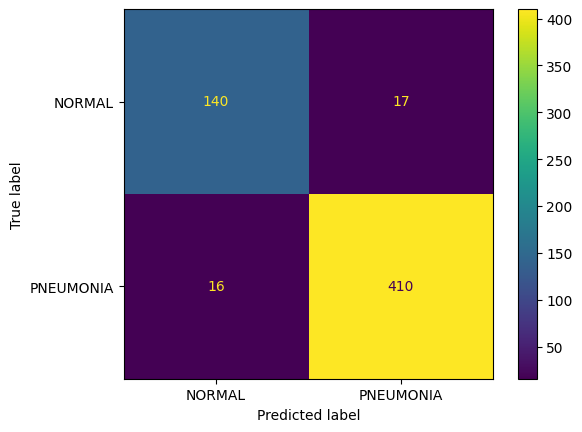

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_51 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_154               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_155               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 4s - 48ms/step - accuracy: 0.7295 - loss: 0.5644 - val_accuracy: 0.7410 - val_loss: 0.4600
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.8676 - loss: 0.3085 - val_accuracy: 0.8954 - val_loss: 0.2348
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.9204 - loss: 0.2057 - val_accuracy: 0.9417 - val_loss: 0.1570
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.9318 - loss: 0.1779 - val_accuracy: 0.9503 - val_loss: 0.1419
Epoch 5/50
83/83 - 1s - 15ms/step - accuracy: 0.9438 - loss: 0.1543 - val_accuracy: 0.9468 - val_loss: 0.1427
Epoch 6/50
83/83 - 1s - 18ms/step - accuracy: 0.9516 - loss: 0.1367 - val_accuracy: 0.9605 - val_loss: 0.1177
Epoch 7/50
83/83 - 1s - 16ms/step - accuracy: 0.9548 - loss: 0.1265 - val_accuracy: 0.9588 - val_loss: 0.1118
Epoch 8/50
83/83 - 1s - 16ms/step - accuracy: 0.9539 - loss: 0.1195 - val_accuracy: 0.9640 - val_loss: 0.1232
Epoch 9/50
83/83 - 1s - 16ms/step - accuracy: 0.9573 - loss: 0.1191 - val_accuracy: 0.9537 - val_loss: 0.1239
Epoch

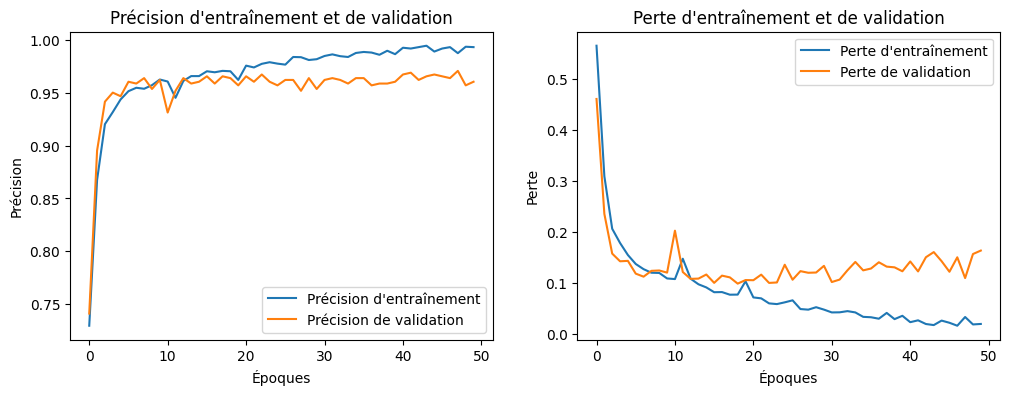

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9442 - loss: 0.2770 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Partition numéro 8:
perte: 0.16 précision: 0.96
AUC 0.9907
Prédictions
Counter({np.int64(1): 427, np.int64(0): 156}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.93      0.92      0.93       157
   Pneumonia       0.97      0.97      0.97       426

    accuracy                           0.96       583
   macro avg       0.95      0.95      0.95       583
weighted avg       0.96      0.96      0.96       583

Matrice de confusion


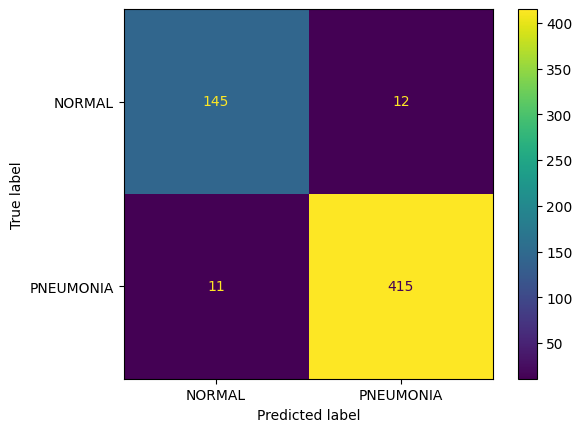

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_52 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_156               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_157               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_158               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_52 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 4s - 43ms/step - accuracy: 0.7403 - loss: 0.5375 - val_accuracy: 0.7822 - val_loss: 0.4532
Epoch 2/50
83/83 - 1s - 16ms/step - accuracy: 0.8101 - loss: 0.4067 - val_accuracy: 0.8902 - val_loss: 0.2704
Epoch 3/50
83/83 - 1s - 15ms/step - accuracy: 0.9074 - loss: 0.2323 - val_accuracy: 0.9022 - val_loss: 0.2099
Epoch 4/50
83/83 - 1s - 16ms/step - accuracy: 0.9362 - loss: 0.1753 - val_accuracy: 0.9314 - val_loss: 0.1964
Epoch 5/50
83/83 - 1s - 16ms/step - accuracy: 0.9404 - loss: 0.1606 - val_accuracy: 0.9160 - val_loss: 0.1852
Epoch 6/50
83/83 - 1s - 15ms/step - accuracy: 0.9474 - loss: 0.1452 - val_accuracy: 0.9365 - val_loss: 0.1490
Epoch 7/50
83/83 - 1s - 16ms/step - accuracy: 0.9495 - loss: 0.1307 - val_accuracy: 0.9314 - val_loss: 0.1679
Epoch 8/50
83/83 - 1s - 15ms/step - accuracy: 0.9522 - loss: 0.1288 - val_accuracy: 0.9331 - val_loss: 0.1534
Epoch 9/50
83/83 - 1s - 16ms/step - accuracy: 0.9558 - loss: 0.1158 - val_accuracy: 0.9417 - val_loss: 0.1435
Epoch

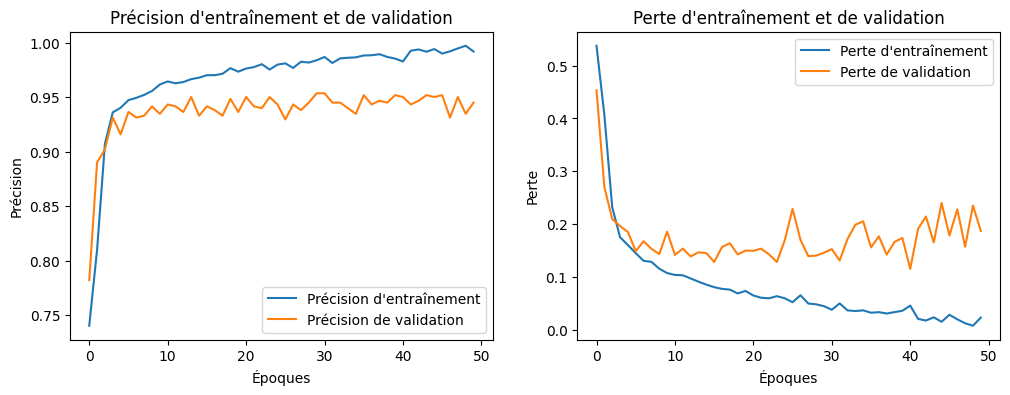

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9294 - loss: 0.2397 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 9:
perte: 0.19 précision: 0.95
AUC 0.9897
Prédictions
Counter({np.int64(1): 424, np.int64(0): 159}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.89      0.90      0.90       157
   Pneumonia       0.96      0.96      0.96       426

    accuracy                           0.95       583
   macro avg       0.93      0.93      0.93       583
weighted avg       0.95      0.95      0.95       583

Matrice de confusion


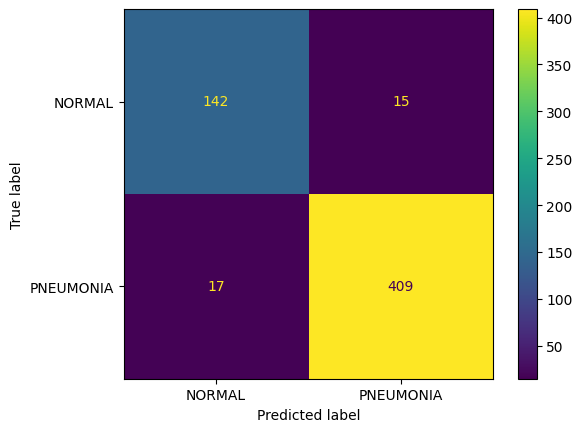

x_train (5249, 32, 32, 1) x_test (583, 32, 32, 1)
y_train (5249,) y_test (583,)


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_53 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_53 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_160               │ (None, 7, 7, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_161               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_53 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 35ms/step - accuracy: 0.7312 - loss: 0.5703 - val_accuracy: 0.8336 - val_loss: 0.3883
Epoch 2/50
83/83 - 1s - 15ms/step - accuracy: 0.8607 - loss: 0.3288 - val_accuracy: 0.9160 - val_loss: 0.2131
Epoch 3/50
83/83 - 1s - 14ms/step - accuracy: 0.9204 - loss: 0.2138 - val_accuracy: 0.9245 - val_loss: 0.1992
Epoch 4/50
83/83 - 1s - 15ms/step - accuracy: 0.9308 - loss: 0.1813 - val_accuracy: 0.9297 - val_loss: 0.1755
Epoch 5/50
83/83 - 1s - 14ms/step - accuracy: 0.9114 - loss: 0.2168 - val_accuracy: 0.9468 - val_loss: 0.1441
Epoch 6/50
83/83 - 1s - 15ms/step - accuracy: 0.9244 - loss: 0.1922 - val_accuracy: 0.9228 - val_loss: 0.2025
Epoch 7/50
83/83 - 1s - 14ms/step - accuracy: 0.9404 - loss: 0.1537 - val_accuracy: 0.9554 - val_loss: 0.1276
Epoch 8/50
83/83 - 1s - 15ms/step - accuracy: 0.9465 - loss: 0.1486 - val_accuracy: 0.9262 - val_loss: 0.1742
Epoch 9/50
83/83 - 1s - 15ms/step - accuracy: 0.9488 - loss: 0.1391 - val_accuracy: 0.9605 - val_loss: 0.1199
Epoch

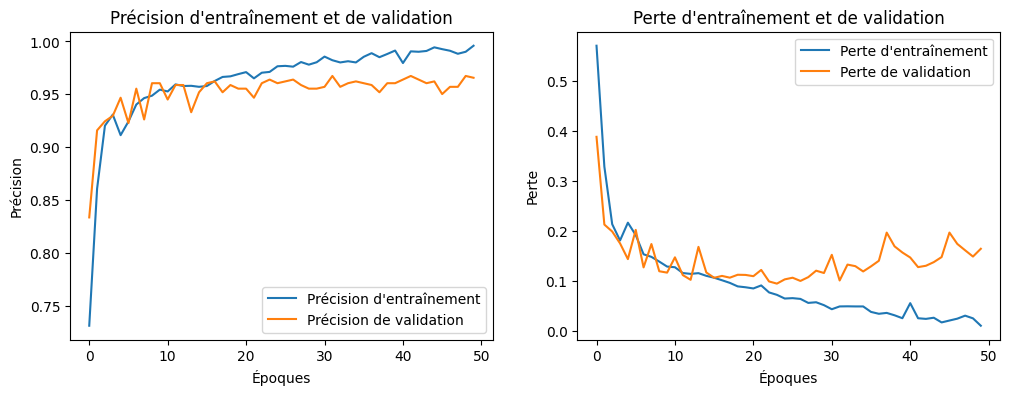

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9606 - loss: 0.1792
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 10:
perte: 0.16 précision: 0.97
AUC 0.9935
Prédictions
Counter({np.int64(1): 424, np.int64(0): 159}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.93      0.94      0.94       157
   Pneumonia       0.98      0.97      0.98       426

    accuracy                           0.97       583
   macro avg       0.95      0.96      0.96       583
weighted avg       0.97      0.97      0.97       583

Matrice de confusion


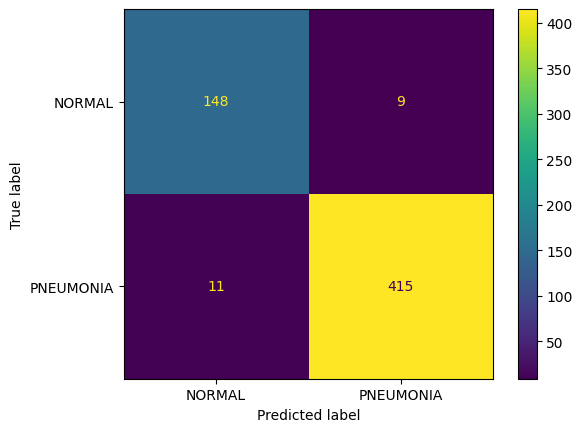

Le meilleur modèle a été sauvegardé avec un ROC de: 0.9941908836988175
Fin de l'entraînement
Résultats ROC:
0.9941908836988175

0.9882703393355916

0.9874906924795235

0.9931943410275502

0.99198808637379

0.9918513202356389

0.9824466971681469

0.9906850871684459

0.9896833228671391

0.9934511527765317

Tableau enregistré avec succès dans 'resultatsROC_1_2.txt'


In [63]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = charger_images_par_format_cv2(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    #90% train | 10% test
    for train_index, test_index in kf.split(X, y):
        # Division des données en ensemble d'entraînement et de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Informations sur les dimensions des données
        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        # Création du modèle
        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        # Compilation du modèle
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entraînement du modèle directement avec les données
        history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_test, y_test), 
            verbose=2)


        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred[:, 1])
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc_1_2.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "resultatsROC_1_2.txt")

if __name__ == '__main__':
    path_save_32x32=r"..\data\processed\images_32x32"
    main(path_save_32x32)
